In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm

import plotly.graph_objects as go

from qec_variables import *

In [2]:
def print_quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            sign = '-' if amplitude.real < 0 else '+'
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign} {abs_amplitude:.2f}|{binary_state}⟩")

    # Removing the first sign
    if superposition and superposition[0][0] == '+':
        superposition[0] = superposition[0][2:]

    superposition_str = ' '.join(superposition).replace('+-', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")

In [3]:
S = [tensor(g) for g in gs]
initial_state = logical_zero
n_qubits = 3

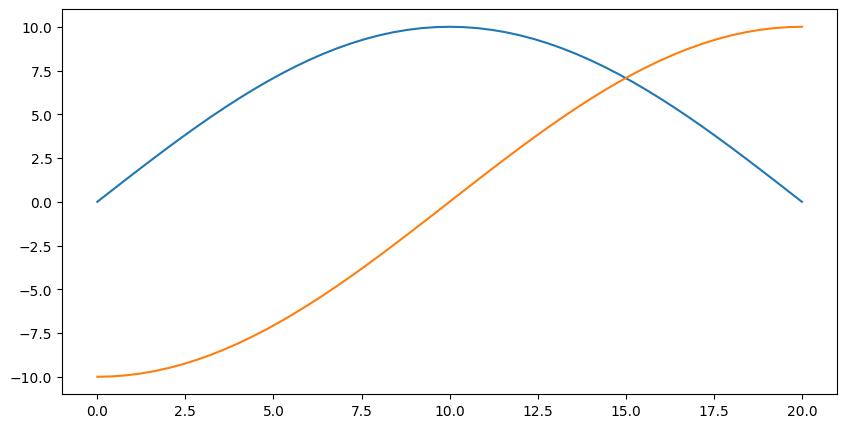

In [4]:
# omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max/2) / sigma) ** 2)
# delta_t = lambda t: 2*omega_max*(t / (T_max/2) - 1)
omega = omega_t(t_list, T_max=T_max, omega_max=omega_max)
delta = delta_t(t_list, T_max=T_max, omega_max=omega_max)

plt.figure(figsize=(10, 5))
plt.plot(t_list, omega)
plt.plot(t_list, delta)

In [5]:
import plotly.graph_objects as go
import os

# Calculate omega and delta
omega = omega_t(t_list, T_max=T_max, omega_max=omega_max)
delta = delta_t(t_list, T_max=T_max, omega_max=omega_max)

# Create the 'pngs' directory if it doesn't exist
os.makedirs('pngs', exist_ok=True)

# Create Plotly figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=t_list, y=omega, mode='lines', name='omega(t)', line=dict(color="#0072B2", width=3)))
fig.add_trace(go.Scatter(x=t_list, y=delta, mode='lines', name='delta(t)', line=dict(color="#D55E00", width=2, dash='dash')))

# PRL-style layout
fig.update_layout(
    title=None,
    font=dict(family="Arial", size=22),
    legend=dict(
        title_text="",
        font=dict(size=18),
        bordercolor="black",
        borderwidth=1,
        x=0.02,
        y=0.98,
        xanchor="left",
        yanchor="top",
        bgcolor="rgba(255,255,255,0.8)"
    ),
    xaxis=dict(
        title=dict(text="Time [a.u.]", font=dict(size=22, family="Arial")),
        tickfont=dict(size=18, family="Arial"),
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        ticks='outside',
        tickwidth=2,
        tickcolor='black'
    ),
    yaxis=dict(
        title=dict(text="Amplitude", font=dict(size=22, family="Arial")),
        tickfont=dict(size=18, family="Arial"),
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        ticks='outside',
        tickwidth=2,
        tickcolor='black'
    ),
    margin=dict(l=80, r=30, t=20, b=80),
    width=800,
    height=600,
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Save the plot as a high-resolution PNG file
try:
    fig.write_image('pngs/omega_delta_PRL.png', format='png', scale=6, width=800, height=600)
    print("Image saved as pngs/omega_delta_PRL.png")
except Exception as e:
    print("Could not export image. Make sure 'kaleido' is installed in the current environment.")
    print("Error:", e)

fig.show()

Image saved as pngs/omega_delta_PRL.png


In [ ]:
# def H_error(t, error_time, strength, duration=2):
#     if error_time <= t < error_time + duration:
#         # ramp_strength = strength * (t - error_time) / duration
#         bit_flip_1 = tensor(X, I, I)
#         bit_flip_2 = tensor(I, X, I)
#         bit_flip_3 = tensor(I, I, X)
#         return strength * bit_flip_1
#     else:
#         # Identity when error is not active
#         return tensor(I, I, I)

# def H_supp(t, stabs=S):
#     H_supp_stab = sum(stabs)
#     return H_supp_stab
    
# def H_total(t, error_time, error_strength, duration, Ep):
#     """
#     Total Hamiltonian including AQC evolution and error simulation.
#     """
#     H_n = H(t) + Ep * H_supp(t) + H_error(t, error_time, error_strength, duration)
#     return H_n


In [7]:
# Ep = -200
# error_time = 6
# duration = T_max - error_time
# error_strength = 50

In [8]:
# # Simulate evolution
# e_ops = [logical_zero*logical_zero.dag(), logical_one*logical_one.dag()]

# result = sesolve(lambda t: H_total(t, error_time, error_strength, duration, Ep),
#                  logical_zero, t_list, e_ops=e_ops,
#                  options={'nsteps': 1e5})

# plt.figure(figsize=(8, 6))
# plt.plot(t_list, result.expect[0], label=r"$|0_L\rangle$ Population", color='red')
# plt.plot(t_list, result.expect[1], label=r"$|1_L\rangle$ Population", color='blue')
# # Add vertical lines for the start and end of the error
# plt.axvline(error_time, color='black', linestyle='--', label="Error Start")
# plt.axvline(error_time + duration, color='black', linestyle='--', label="Error End")

# # Shade the area between the lines
# plt.fill_betweenx(
#     [0, 1],  # Adjust y-limits based on your data range
#     error_time,
#     error_time + duration,
#     color='gray',
#     alpha=0.3,
#     label="Error Region"
# )

# plt.xlabel("Time (t)")
# plt.ylabel("Population")
# plt.title("Logical State Populations with Bit-Flip Error")
# plt.legend()
# plt.grid()
# plt.show()

In [120]:
Ep = 40
Hp = -Ep * sum(S)
# Calculate the initial Hamiltonian eigenstates

H_S_0 = H(0) + Hp
eigenvalues_0, eigenstates_0 = H_S_0.eigenstates()

# Initialize storage for the first two eigenstates and the rest
states = {index: [eigenvalues_0[index]] for index in range(len(eigenvalues_0))}

# Loop through time steps
for t_step in range(1, len(t_list)):
    H_S = H(t_list[t_step]) + Hp
    eigenvalues, eigenstates = H_S.eigenstates()

    # Handle the first two eigenstates with overlap matching
    for state_index in range(2):  # Restrict to the first two eigenstates of H_S_0
        state_0 = eigenstates_0[state_index]
        max_overlap = 0
        best_match_index = 0

        for i, state_t in enumerate(eigenstates):
            proj = np.abs(state_0.overlap(state_t))**2
            if proj > max_overlap:
                max_overlap = proj
                best_match_index = i

        # Append the best matching eigenvalue for the first two eigenstates
        states[state_index].append(eigenvalues[best_match_index])

    # For the remaining eigenstates, just append their eigenvalues directly
    for state_index in range(2, len(eigenvalues)):
        states[state_index].append(eigenvalues[state_index])

# Create the plot
fig = go.Figure()

colors = ['red', 'blue']
for state_index, energies in states.items():
    if state_index < 2:  # Highlight the first two eigenstates
        fig.add_trace(go.Scatter(
            x=t_list,
            y=energies,
            mode='lines',
            line=dict(color=colors[state_index % len(colors)], width=2),
            name=f"Eigenstate {state_index + 1}"
        ))
    else:  # Plot the rest as dashed lines
        fig.add_trace(go.Scatter(
            x=t_list,
            y=energies,
            mode='lines',
            line=dict(color='black', width=1, dash='dash'),
            name=f"Eigenstate {state_index + 1}"
        ))

# Update layout
fig.update_layout(
    title="Energy Spectrum as a Function of Time",
    xaxis_title="Time [a.u.]",
    yaxis_title="Energy",
    font=dict(family="sans-serif", size=18),
    legend_title="Eigenstates",
    template="plotly"
)

# Show the plot
fig.show()

In [10]:
# Save the previous figure as a high-resolution PNG in PRL style (no grid)
import os
import plotly.io as pio

# Ensure the 'pngs' directory exists
os.makedirs('pngs', exist_ok=True)

# Update to PRL-style layout (no grid lines)
fig.update_layout(
    title=None,
    font=dict(family="Arial", size=22),
    legend=dict(
        title_text="",
        font=dict(size=18),
        bordercolor="black",
        borderwidth=1,
        x=0.02,
        y=0.98,
        xanchor="left",
        yanchor="top",
        bgcolor="rgba(255,255,255,0.8)"
    ),
    xaxis=dict(
        title=dict(text="Time [a.u.]", font=dict(size=22, family="Arial")),
        tickfont=dict(size=18, family="Arial"),
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        ticks='outside',
        tickwidth=2,
        tickcolor='black',
        showgrid=False
    ),
    yaxis=dict(
        title=dict(text="Energy", font=dict(size=22, family="Arial")),
        tickfont=dict(size=18, family="Arial"),
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        ticks='outside',
        tickwidth=2,
        tickcolor='black',
        showgrid=False
    ),
    margin=dict(l=80, r=30, t=20, b=80),
    width=800,
    height=600,
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Save as high-res PNG
try:
    fig.write_image('pngs/energy_spectrum_PRL.png', format='png', scale=6, width=800, height=600)
    print("Image saved as pngs/energy_spectrum_PRL.png")
except Exception as e:
    print("Could not export image. Make sure 'kaleido' is installed in the current environment.")
    print("Error:", e)

Image saved as pngs/energy_spectrum_PRL.png


In [11]:
# Save the previous figure as a high-resolution PNG in PRL style
import os
import plotly.io as pio

# Ensure the 'pngs' directory exists
os.makedirs('pngs', exist_ok=True)

# Update to PRL-style layout
fig.update_layout(
    title=None,
    font=dict(family="Arial", size=22),
    legend=dict(
        title_text="",
        font=dict(size=18),
        bordercolor="black",
        borderwidth=1,
        x=0.02,
        y=0.98,
        xanchor="left",
        yanchor="top",
        bgcolor="rgba(255,255,255,0.8)"
    ),
    xaxis=dict(
        title=dict(text="Time [a.u.]", font=dict(size=22, family="Arial")),
        tickfont=dict(size=18, family="Arial"),
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        ticks='outside',
        tickwidth=2,
        tickcolor='black'
    ),
    yaxis=dict(
        title=dict(text="Energy", font=dict(size=22, family="Arial")),
        tickfont=dict(size=18, family="Arial"),
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        ticks='outside',
        tickwidth=2,
        tickcolor='black'
    ),
    margin=dict(l=80, r=30, t=20, b=80),
    width=800,
    height=600,
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Save as high-res PNG
try:
    fig.write_image('pngs/energy_spectrum_PRL.png', format='png', scale=6, width=800, height=600)
    print("Image saved as pngs/energy_spectrum_PRL.png")
except Exception as e:
    print("Could not export image. Make sure 'kaleido' is installed in the current environment.")
    print("Error:", e)

Image saved as pngs/energy_spectrum_PRL.png


In [12]:
def bose_einstein_distribution(energy_diff, temperature):
    if temperature == 0:
        return 0
    return 1 / (np.exp(energy_diff / (temperature)) - 1)

def gab(omega1, omega2, lambda_2):
    if omega1 >= omega2:
        return 0
    return np.sqrt(lambda_2)

def c_ops_gen_new(t, args):
    H_inst_t = args['args_H'](t)  # Instantaneous Hamiltonian at time t
    eigenvalues, eigenstates = H_inst_t.eigenstates()
    c_s = []
    c_ops = []
    for a_i, a in enumerate(eigenstates):

        omega_a = eigenvalues[a_i]
        for b_i, b in enumerate(eigenstates[a_i+1:]):
            omega_b = eigenvalues[a_i + b_i + 1]
            
            c = b*a.dag()
            c_coef = 0
            for i in range(args['n_qubits']):
                sigmam_i = tensor([sigmam() if j == i else I for j in range(args['n_qubits'])])
                
                if np.abs(omega_a - omega_b) < 1e-6:
                    continue  # Skip nearly degenerate states
                
                # For decay transitions (omega_b > omega_a)
                if omega_b > omega_a:
                    Nba = bose_einstein_distribution(omega_b - omega_a, args['T'])
                    g_ba = gab(omega_a, omega_b, args['lambda_2'])

                    ma_ba = a.dag() * sigmam_i * b * b.dag() * sigmam_i.dag() * a
                    decay_op = np.sqrt(Nba * (g_ba ** 2) * ma_ba)
                    c_coef += decay_op

                # For excitation transitions (omega_a > omega_b)
                elif omega_a > omega_b:
                    Nab = bose_einstein_distribution(omega_a - omega_b, args['T'])
                    g_ab = gab(omega_b, omega_a, args['lambda_2'])
                    ma_ab = b.dag() * sigmam_i * a * a.dag() * sigmam_i.dag() * b
                    excitation_op = np.sqrt((Nab + 1) * (g_ab ** 2) * ma_ab)                    
                    c_coef += excitation_op
                    
                    
            if c_coef > 1e-5:
                c_ops.append(c.to('csr')*c_coef)
                c_s.append(c_coef)
            else:
                c_s.append(0)

    return c_ops, c_s

|ψ⟩ = 1.00|000⟩
0
1
1
2
2
3
3
4
4
5
5
10
10
25
25
50
50


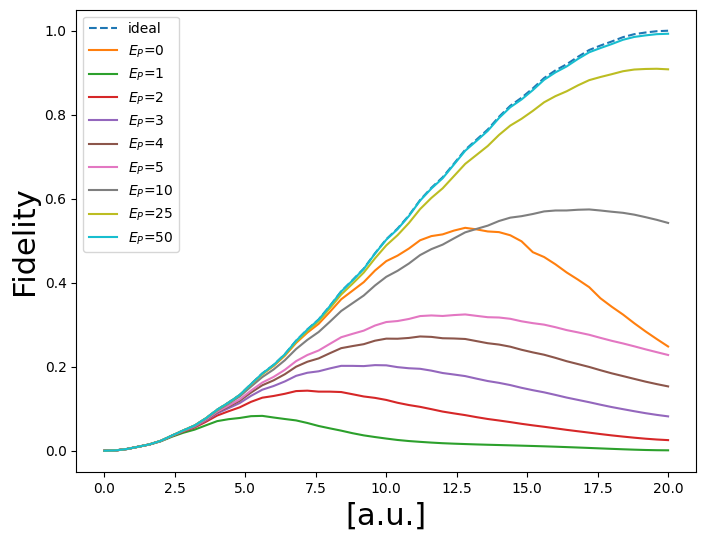

Done


In [13]:
print_quantum_state_as_superposition(initial_state)

gamma_sqrt = 0.1
T = 20 # temp

# Eps = [0, 50, 100, 200, 300]
Eps = [0, 1, 2, 3, 4, 5, 10, 25, 50]

rho0 = logical_zero * logical_zero.dag()
rho1 = logical_one * logical_one.dag()
e_ops = [rho0, rho1]

plt.figure(figsize=(8, 6))


results_se = sesolve(H, logical_zero, t_list, e_ops=e_ops)
plt.plot(t_list, results_se.expect[1], linestyle="--", label=r"ideal")

# Loop over different values of Ep
for Ep in Eps:
    print(Ep)
    rho_init = initial_state * initial_state.dag()
    e_ops = [rho0, rho1]
    
    # Time-dependent Hamiltonian
    def H_t(t):
        H_RAP = H(t)
        
        Ht = H_RAP - Ep * sum(S)
        return Ht.to('csr')  # Assuming H_x and H_z are valid Qobjs

    args_C = {"args_H": H_t,
              "n_qubits": n_qubits,
              "lambda_2":gamma_sqrt,
              "T":T}

    prev_time = t_list[0]
    expects_0 = []
    expects_1 = []

    time_inter = t_list[1] - t_list[0]

    tot_time = t_list[1:]
    tot_time = np.append(tot_time, t_list[-1] + time_inter)

    for dt in tot_time:
        c_ops, c_s = c_ops_gen_new(dt, args=args_C)
        # c_ops = [i*1e-1 for i in [tensor(sigmam(),I,I), tensor(I,sigmam(),I), tensor(I,I,sigmam())]]

        t_steps = [prev_time, dt]
        results = mesolve(H_t, rho_init, t_steps, c_ops=c_ops, args=args_C, e_ops=e_ops,
                          options={'store_states': True})

        # Updating
        prev_time = dt
        rho_init = results.states[-1]

        # Saving
        expects_1.append(results.expect[1][0])
        expects_0.append(results.expect[0][0])
    
    # Plotting results
    expects_all = [expects_1[i] for i in range(len(expects_1))]

    plt.plot(t_list, expects_all, label=r"$E_{P}$=" + str(Ep))


plt.legend()
plt.xlabel('[a.u.]', size=22)
plt.ylabel('Fidelity', size=22)
plt.show()
plt.close()

print("Done")

# Plotting the evolution of transition coefficients (c_coef) over time
The plot illustrates the evolution of transition coefficients (c_coef) over time for various quantum state transitions. Notably, the transitions involving (0, i) and (1, i) remain consistently low throughout the protocol. This behavior is crucial as it ensures that the logical state remains confined to the ground space, preserving the fidelity of the quantum computation and minimizing leakage to higher energy states. This characteristic is essential for maintaining the robustness of the logical qubit during the adiabatic evolution.

In [14]:
def c_ops_gen_new_with_tracking(t, args):
    H_inst_t = args['args_H'](t)  # Instantaneous Hamiltonian at time t
    eigenvalues, eigenstates = H_inst_t.eigenstates()
    c_coef_tracking = {}
    for a_i, a in enumerate(eigenstates):
        omega_a = eigenvalues[a_i]
        for b_i, b in enumerate(eigenstates[a_i+1:]):
            omega_b = eigenvalues[a_i + b_i + 1]
            c_coef = 0
            for i in range(args['n_qubits']):
                sigmam_i = tensor([sigmam() if j == i else qeye(2) for j in range(args['n_qubits'])])
                if np.abs(omega_a - omega_b) < 1e-6:
                    continue  # Skip nearly degenerate states
                if omega_b > omega_a:  # Decay transitions
                    Nba = bose_einstein_distribution(omega_b - omega_a, args['T'])
                    g_ba = gab(omega_a, omega_b, args['lambda_2'])
                    ma_ba = a.dag() * sigmam_i * b * b.dag() * sigmam_i.dag() * a
                    c_coef += np.sqrt(Nba * (g_ba ** 2) * ma_ba)
                elif omega_a > omega_b:  # Excitation transitions
                    Nab = bose_einstein_distribution(omega_a - omega_b, args['T'])
                    g_ab = gab(omega_b, omega_a, args['lambda_2'])
                    ma_ab = b.dag() * sigmam_i * a * a.dag() * sigmam_i.dag() * b
                    c_coef += np.sqrt((Nab + 1) * (g_ab ** 2) * ma_ab)
            # Store c_coef for transition (a_i, b_i)
            transition_key = (a_i, a_i + b_i + 1)
            if transition_key not in c_coef_tracking:
                c_coef_tracking[transition_key] = []
            c_coef_tracking[transition_key].append(c_coef)
    return c_coef_tracking


In [15]:
import plotly.graph_objects as go
# Initialize c_coef_tracking
c_coef_tracking = {}

Ep = 1
# Define args
args = {
    "args_H": lambda t: omega_t(t) * X_L + delta_t(t) * Z_L - Ep * sum(S),
    "n_qubits": 3,
    "lambda_2": 0.01,
    "T": 20
}

for t in t_list:
    c_coef_t = c_ops_gen_new_with_tracking(t, args)
    for key, values in c_coef_t.items():
        if key[0] != 0: # and key[0] != 1:
            continue  # Skip transitions that are not (0, i) or (1, i)
        if key not in c_coef_tracking:
            c_coef_tracking[key] = []
        # Convert complex values to real values (e.g., absolute values)
        c_coef_tracking[key].extend([np.abs(value) for value in values])

# Create interactive plot
fig = go.Figure()

for transition, coefs in c_coef_tracking.items():
    fig.add_trace(go.Scatter(
        x=t_list,
        y=coefs[:len(t_list)],
        mode='markers',
        name=f"Transition {transition}"  # Label for hover/click
    ))

fig.update_layout(
    title="Evolution of c_coef Per Transition Over Time",
    xaxis_title="Time",
    yaxis_title="c_coef",
    legend_title="Transitions",
    template="plotly"
)

fig.show()

### Notes on the final-fidelity vs summed collapse-coefficients plot
- What is shown: the figure plots the simulated final fidelity of the logical state \(|1_L\rangle\) against the protocol-wide sum of collapse-operator coefficients (we sum the absolute values returned by `c_ops_gen_new_with_tracking`) for various temperatures; each curve corresponds to a different temperature and Ep sweep.
- How it was computed: for every pair ($E_p$, T) the code accumulates |c_coef(t)| across all time steps, then propagates the density matrix piecewise using `c_ops_gen_new` for each segment and measures \(F_{final}=\langle1_L|\rho_{final}|1_L\rangle\). The summed coefficient is used as a heuristic proxy for effective bath coupling during the protocol.
- Interpretation: larger summed coefficients typically indicate stronger effective coupling to the bath and correlate with lower final fidelity; smaller sums correlate with higher fidelity. This plot therefore provides an empirical, protocol-level diagnostic linking the collapse-operator strength to logical fidelity.
- Caveats: the summed coefficients are a heuristic proxy — the result depends on the exact format and normalization of `c_ops_gen_new_with_tracking` and on the coarse Ep/T grid and piecewise propagation. For quantitative error bounds use spectral-density-based rate calculations or refine the Ep grid around thresholds.
- Suggested follow-ups: refine `Ep_vec` near the threshold, validate predictions by sweeping Ep and directly plotting measured F vs Ep, or replace the proxy with integrated transition rates computed from the bath spectral density.

In [16]:
import numpy as np
from tqdm import tqdm
import plotly.graph_objects as go

# grids (adjust as needed)
Ep_vec = np.linspace(1, 100, 21)
T_vec = np.linspace(1, 50, 10)
lambda_2 = 0.01

# storage
results_by_T = {T: {'sum_coefs': [], 'fid': [], 'Ep': []} for T in T_vec}

# e_ops and initial states
rho0 = logical_zero * logical_zero.dag()
rho1 = logical_one * logical_one.dag()
e_ops = [rho0, rho1]

for T in tqdm(T_vec, desc="Temperatures"):
    for Ep in tqdm(Ep_vec, desc=f"Ep (T={T:.2f})", leave=False):
        # time-dependent Hamiltonian with penalty -Ep*sum(S)
        def H_t(t):
            H_RAP = H(t)
            Ht = H_RAP - Ep * sum(S)
            return Ht.to('csr')

        # args for generators
        args_C = {"args_H": H_t, "n_qubits": 3, "lambda_2": lambda_2, "T": T}

        # 1) accumulate sum of tracked coefficients across protocol
        sum_coefs = 0.0
        try:
            for t in t_list:
                c_coef_t = c_ops_gen_new_with_tracking(t, args_C)  # expected dict-like
                # flatten and sum absolute values
                if isinstance(c_coef_t, dict):
                    for key, vals in c_coef_t.items():
                        # optional filter: only consider transitions starting from 0 (key[0]==0)
                        try:
                            if key[0] != 0:
                                continue
                        except Exception:
                            pass
                        if isinstance(vals, (list, tuple, np.ndarray)):
                            sum_coefs += np.sum(np.abs(np.array(vals, dtype=float)))
                        else:
                            try:
                                sum_coefs += float(np.abs(vals))
                            except Exception:
                                pass
                elif isinstance(c_coef_t, (list, tuple, np.ndarray)):
                    # fallback: treat as numeric list
                    sum_coefs += np.sum(np.abs(np.array(c_coef_t, dtype=float)))
                else:
                    # unknown format: ignore
                    pass
        except Exception:
            # if tracking generator fails, record zero (or np.nan) and continue
            sum_coefs = np.nan

        # 2) piecewise propagation using c_ops_gen_new (fall back to unitary segments if needed)
        rho_init = logical_zero * logical_zero.dag()
        prev_time = t_list[0]
        final_fid = np.nan
        try:
            for dt in t_list[1:]:
                # request collapse operators for this segment (at time dt)
                try:
                    c_ops_segment, _ = c_ops_gen_new(dt, args=args_C)
                except Exception:
                    # try without tuple return
                    try:
                        c_ops_segment = c_ops_gen_new(dt, args=args_C)
                    except Exception:
                        c_ops_segment = None
                t_steps = [prev_time, dt]
                try:
                    results = mesolve(H_t, rho_init, t_steps, c_ops=c_ops_segment, args=args_C, e_ops=e_ops, options={'store_states': True})
                except Exception:
                    # fallback to no collapse ops for this segment
                    results = mesolve(H_t, rho_init, t_steps, c_ops=None, args=args_C, e_ops=e_ops, options={'store_states': True})
                prev_time = dt
                rho_init = results.states[-1]
            final_fid = float(np.real(results.expect[1][-1]))
        except Exception:
            final_fid = np.nan

        # store
        results_by_T[T]['sum_coefs'].append(sum_coefs)
        results_by_T[T]['fid'].append(final_fid)
        results_by_T[T]['Ep'].append(Ep)

# Plot final fidelity vs summed coefficients (one curve per T)
fig = go.Figure()
for T, data in results_by_T.items():
    x = np.array(data['sum_coefs'], dtype=float)
    y = np.array(data['fid'], dtype=float)
    # drop nan x values for plotting
    valid = np.isfinite(x) & np.isfinite(y)
    if np.any(valid):
        fig.add_trace(go.Scatter(
            x=x[valid],
            y=y[valid],
            mode='lines+markers',
            name=f"T={T:.2f}"
        ))
fig.update_xaxes(title_text='Sum of |c_coef| over protocol (proxy)')
fig.update_yaxes(title_text='Final fidelity of |1_L>')
fig.update_layout(title='Final fidelity vs summed collapse-coefficients for different T', template='simple_white')
fig.show()

# Optional: also show Ep vs sum_coefs color-coded by T
fig2 = go.Figure()
for T, data in results_by_T.items():
    x = np.array(data['Ep'], dtype=float)
    y = np.array(data['sum_coefs'], dtype=float)
    valid = np.isfinite(x) & np.isfinite(y)
    if np.any(valid):
        fig2.add_trace(go.Scatter(x=x[valid], y=y[valid], mode='lines+markers', name=f"T={T:.2f}"))
fig2.update_xaxes(title_text='E_p')
fig2.update_yaxes(title_text='Sum of |c_coef| over protocol')
fig2.update_layout(title='Sum of collapse-coefficients vs E_p (by T)', template='simple_white')
fig2.show()

Temperatures:   0%|          | 0/10 [00:00<?, ?it/s]/var/folders/sn/yn8dgjs53ml_hdwfm9mp_fyh0000gn/T/ipykernel_94692/1242815572.py:44: ComplexWarning:

Casting complex values to real discards the imaginary part

/var/folders/sn/yn8dgjs53ml_hdwfm9mp_fyh0000gn/T/ipykernel_94692/1242815572.py:44: ComplexWarning:

Casting complex values to real discards the imaginary part

Temperatures: 100%|██████████| 10/10 [02:02<00:00, 12.27s/it]



### Summary of Ep/T-family plots
- What the plots show: each curve corresponds to a fixed dimensionless family $E_p/T$. Points along a curve are generated by varying the temperature \(T\) while keeping \(E_p=\beta T\).
- First figure: predicted final fidelity of the logical state $|1_L\rangle$ versus the protocol-wide sum of collapse-op coefficients (computed at sampled times). Each curve (one per $E_p/T$ shows how fidelity degrades as the effective coupling (sum of coefficients) increases for that \(E_p/T\) family.
- Key details and caveats: results use sampled times to reduce runtime and the `c_ops_gen_new_with_tracking` outputs as a heuristic proxy (sum of |coeffs|). Propagation used piecewise `mesolve` on the sampled grid. These are empirical, protocol-level diagnostics — for quantitative error bounds use a denser sampling, refine the $E_p/T$ grid, or compute rate integrals from the bath spectral density.
- Suggested next steps: refine the sampling near threshold regions, interpolate onto continuous \(E_p/T\) slices for smoother curves, or validate by a direct sweep of $E_p$ at fixed temperatures and comparing observed fidelity to the model predictions.

In [38]:
# Reduced grids for speed
beta_list = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]      # Ep/T families (Ep/T)
T_vec = np.linspace(1, 50, 20)               # temperatures to sweep (coarse)
lambda_2 = 0.1

# sample times to reduce cost (pick ~20 evenly spaced times from t_list)
max_samples = 20
step = max(1, len(t_list) // max_samples)
sampled_t_list = t_list[::step]
# ensure last time included
if sampled_t_list[-1] != t_list[-1]:
    sampled_t_list = np.concatenate((sampled_t_list, [t_list[-1]]))

results_by_beta = {}

for beta in beta_list:
    sums_per_T = []
    fid_per_T = []
    Ep_per_T = []
    for T in tqdm(T_vec, desc=f"β={beta}", leave=False):
        Ep = beta * T
        Ep_per_T.append(Ep)

        # time-dependent Hamiltonian for this Ep
        def H_t_local(t):
            return (H(t) - Ep * sum(S)).to('csr')

        args_C = {"args_H": H_t_local, "n_qubits": 3, "lambda_2": lambda_2, "T": T}

        # 1) accumulate sum of tracked coefficients using sampled times
        sum_coefs = 0.0
        try:
            for tt in sampled_t_list:
                c_coef_t = c_ops_gen_new_with_tracking(tt, args_C)  # expected dict-like
                if isinstance(c_coef_t, dict):
                    for key, vals in c_coef_t.items():
                        # optional filter: only consider transitions starting from 0
                        try:
                            if key[0] != 0:
                                continue
                        except Exception:
                            pass
                        if isinstance(vals, (list, tuple, np.ndarray)):
                            sum_coefs += np.sum(np.abs(np.array(vals, dtype=float)))
                        else:
                            try:
                                sum_coefs += float(np.abs(vals))
                            except Exception:
                                pass
                elif isinstance(c_coef_t, (list, tuple, np.ndarray)):
                    sum_coefs += np.sum(np.abs(np.array(c_coef_t, dtype=float)))
                else:
                    pass
        except Exception:
            sum_coefs = np.nan
        # record sampled sum for this T
        sums_per_T.append(sum_coefs)

        # 2) piecewise propagation using sampled_t_list to reduce mesolve calls
        rho = logical_zero * logical_zero.dag()
        prev_time = sampled_t_list[0]
        final_fid = np.nan
        try:
            for dt in sampled_t_list[1:]:
                # request collapse operators for segment at dt
                try:
                    c_ops_segment, _ = c_ops_gen_new(dt, args=args_C)
                except Exception:
                    try:
                        c_ops_segment = c_ops_gen_new(dt, args=args_C)
                    except Exception:
                        c_ops_segment = None
                t_steps = [prev_time, dt]
                try:
                    results = mesolve(H_t_local, rho, t_steps, c_ops=c_ops_segment, args=args_C, e_ops=[logical_zero*logical_zero.dag(), logical_one*logical_one.dag()], options={'store_states': True})
                except Exception:
                    results = mesolve(H_t_local, rho, t_steps, c_ops=None, args=args_C, e_ops=[logical_zero*logical_zero.dag(), logical_one*logical_one.dag()], options={'store_states': True})
                prev_time = dt
                rho = results.states[-1]
            final_fid = float(np.real(results.expect[1][-1]))
        except Exception:
            final_fid = np.nan
        # record final fidelity for this T
        fid_per_T.append(final_fid)

    # store results for this beta after sweeping all T
    results_by_beta[beta] = {
        "T": T_vec.copy(),
        "Ep": np.array(Ep_per_T),
        "sum_coefs": np.array(sums_per_T),
        "fid": np.array(fid_per_T)
    }

# Plot 1: final fidelity vs sum_coefs, one curve per beta
fig1 = go.Figure()
for beta, data in results_by_beta.items():
    x = data["sum_coefs"]
    y = data["fid"]
    valid = np.isfinite(x) & np.isfinite(y)
    if np.any(valid):
        # sort by x for nicer lines
        idx = np.argsort(x[valid])
        fig1.add_trace(go.Scatter(x=x[valid][idx], y=y[valid][idx], mode='lines+markers', name=f'Ep/T={beta}'))
fig1.update_xaxes(title_text='Sum of |c_coef| over protocol (proxy, sampled times)', type='log')
fig1.update_yaxes(title_text='Final fidelity of |1_L>')
fig1.update_layout(title='Final fidelity vs summed collapse-coefs (curves = Ep/T families)', template='simple_white')
fig1.show()


# Optional: small table printout for inspection
for beta, data in results_by_beta.items():
    print(f"\nβ = {beta}:")
    for T, Ep, s, f in zip(data["T"], data["Ep"], data["sum_coefs"], data["fid"]):
        print(f"  T={T:.2f}, Ep={Ep:.2f}, sum_coef={s:.3e}, fid={f if not np.isnan(f) else 'nan'}")

β=0.1:   0%|          | 0/20 [00:00<?, ?it/s]/var/folders/sn/yn8dgjs53ml_hdwfm9mp_fyh0000gn/T/ipykernel_94692/4191906356.py:44: ComplexWarning:

Casting complex values to real discards the imaginary part

/var/folders/sn/yn8dgjs53ml_hdwfm9mp_fyh0000gn/T/ipykernel_94692/4191906356.py:44: ComplexWarning:

Casting complex values to real discards the imaginary part

                                                       


β = 0.1:
  T=1.00, Ep=0.10, sum_coef=1.427e+01, fid=0.0628701660276743
  T=3.58, Ep=0.36, sum_coef=1.493e+01, fid=0.062445852919989206
  T=6.16, Ep=0.62, sum_coef=1.643e+01, fid=0.05848577723721709
  T=8.74, Ep=0.87, sum_coef=1.785e+01, fid=0.05155594245708088
  T=11.32, Ep=1.13, sum_coef=1.906e+01, fid=0.04408623554726931
  T=13.89, Ep=1.39, sum_coef=2.009e+01, fid=0.03724141741660547
  T=16.47, Ep=1.65, sum_coef=2.098e+01, fid=0.0313597649735564
  T=19.05, Ep=1.91, sum_coef=2.175e+01, fid=0.026441303599316113
  T=21.63, Ep=2.16, sum_coef=2.244e+01, fid=0.022372604892704314
  T=24.21, Ep=2.42, sum_coef=2.306e+01, fid=0.019016505549661267
  T=26.79, Ep=2.68, sum_coef=2.362e+01, fid=0.016244737111374686
  T=29.37, Ep=2.94, sum_coef=2.413e+01, fid=0.01394786532491238
  T=31.95, Ep=3.19, sum_coef=2.459e+01, fid=0.01203624972235495
  T=34.53, Ep=3.45, sum_coef=2.502e+01, fid=0.010437988970225305
  T=37.11, Ep=3.71, sum_coef=2.542e+01, fid=0.009096028410442656
  T=39.68, Ep=3.97, sum_coef=

# As function of energy gap


## Simulating the final fidelity of the logical state |1_L⟩ as a function of the energy gap E_P at different temperatures

In [20]:
# Define parameters
gamma_sqrt = 0.1
temperatures = [1, 10, 20, 50, 100]  # Different temperatures
Eps = np.linspace(1, 50, 20)  # Energy gaps


# Initialize data storage
final_fidelities = {T: [] for T in temperatures}

# Loop over temperatures
for T in temperatures:
    print(f"Processing temperature: {T}")
    for Ep in Eps:
        # Time-dependent Hamiltonian
        def H_t(t):
            H_RAP = H(t)
            Ht = H_RAP - Ep * sum(S)
            return Ht.to('csr')

        args_C = {"args_H": H_t, "n_qubits": n_qubits, "lambda_2": gamma_sqrt, "T": T}

        # Simulate evolution
        rho_init = initial_state * initial_state.dag()
        prev_time = t_list[0]
        time_inter = t_list[1] - t_list[0]
        tot_time = t_list[1:]
        tot_time = np.append(tot_time, t_list[-1] + time_inter)

        for dt in tot_time:
            c_ops, c_s = c_ops_gen_new(dt, args=args_C)
            t_steps = [prev_time, dt]
            results = mesolve(H_t, rho_init, t_steps, c_ops=c_ops, args=args_C, e_ops=e_ops,
                              options={'store_states': True})
            prev_time = dt
            rho_init = results.states[-1]

        # Store final fidelity for logical_one state
        final_fidelity = results.expect[1][-1]
        final_fidelities[T].append(final_fidelity)

# Create interactive plot
fig = go.Figure()

for T, fidelities in final_fidelities.items():
    fig.add_trace(go.Scatter(
        x=Eps,
        y=fidelities,
        mode='lines+markers',
        name=f"T = {T} K"
    ))

fig.update_layout(
    title=r"Final Fidelity of $|1_L\rangle$",
    xaxis_title="Energy Gap",
    yaxis_title=r"Final Fidelity of $|1_L\rangle$"
)

fig.show()

Processing temperature: 1
Processing temperature: 10
Processing temperature: 10
Processing temperature: 20
Processing temperature: 20
Processing temperature: 50
Processing temperature: 50
Processing temperature: 100
Processing temperature: 100


## Simulating the final fidelity of the logical state |1_L⟩ as a function of the energy gap E_P for different gamma_sqrt values

In [21]:
# Define parameters
temperature = 20  # Constant temperature
gamma_sqrt_values = [0.05, 0.1, 0.2, 0.5, 1.0]  # Different gamma_sqrt values
Eps = np.linspace(1, 50, 20)  # Energy gaps

rho0 = logical_zero * logical_zero.dag()
rho1 = logical_one * logical_one.dag()
e_ops = [rho0, rho1]

# Initialize data storage
final_fidelities = {gamma: [] for gamma in gamma_sqrt_values}

# Loop over gamma_sqrt values
for gamma_sqrt in gamma_sqrt_values:
    print(f"Processing gamma_sqrt: {gamma_sqrt}")
    for Ep in Eps:
        # Time-dependent Hamiltonian
        def H_t(t):
            H_RAP = X_L * omega_t(t) + Z_L * delta_t(t)
            Ht = H_RAP - Ep * sum(S)
            return Ht.to('csr')

        args_C = {"args_H": H_t, "n_qubits": n_qubits, "lambda_2": gamma_sqrt, "T": temperature}

        # Simulate evolution
        rho_init = initial_state * initial_state.dag()
        prev_time = t_list[0]
        time_inter = t_list[1] - t_list[0]
        tot_time = t_list[1:]
        tot_time = np.append(tot_time, t_list[-1] + time_inter)

        for dt in tot_time:
            c_ops, c_s = c_ops_gen_new(dt, args=args_C)
            t_steps = [prev_time, dt]
            results = mesolve(H_t, rho_init, t_steps, c_ops=c_ops, args=args_C, e_ops=e_ops,
                              options={'store_states': True})
            prev_time = dt
            rho_init = results.states[-1]

        # Store final fidelity for logical_one state
        final_fidelity = results.expect[1][-1]
        final_fidelities[gamma_sqrt].append(final_fidelity)

# Create interactive plot
fig = go.Figure()

for gamma_sqrt, fidelities in final_fidelities.items():
    fig.add_trace(go.Scatter(
        x=Eps,
        y=fidelities,
        mode='lines+markers',
        name=f"gamma_sqrt = {gamma_sqrt}"
    ))

fig.update_layout(
    title=r"Final Fidelity of $|1_L\rangle$",
    xaxis_title="Energy Gap",
    yaxis_title=r"Final Fidelity of $|1_L\rangle$"
)

fig.show()

Processing gamma_sqrt: 0.05
Processing gamma_sqrt: 0.1
Processing gamma_sqrt: 0.1
Processing gamma_sqrt: 0.2
Processing gamma_sqrt: 0.2
Processing gamma_sqrt: 0.5
Processing gamma_sqrt: 0.5
Processing gamma_sqrt: 1.0
Processing gamma_sqrt: 1.0


### Explanation of the Required $E_p$ plots
- What is shown: the first plot shows the required penalty strength $E_p$ (the smallest $E_p$ in the sweep) that yields a final fidelity ≥ 0.95 for the logical state $|1_L\rangle$ as a function of temperature $T$. The second plot shows the same required $E_p$ plotted against the corresponding thermal occupancy $n_{th}$ (Bose–Einstein) estimated from the protocol energy gap.
- How it was computed: for each temperature in `T_vec` we swept a vector of `Ep_vec`; for each $(E_p,T)$ we constructed the time-dependent Hamiltonian $H(t)-E_p\sum S$, generated the collapse operators with `c_ops_gen_new`, propagated the state piecewise with `mesolve`, and measured the final fidelity as \(F=\langle 1_L|\rho_{final}|1_L\rangle\). The first $E_p$ reaching $F\ge0.95$ was recorded as the required value. The corresponding $n_{th}$ is obtained from the protocol energy gap via the Bose–Einstein factor.
- Key assumptions / caveats: the result depends on the collapse-operator generator (`c_ops_gen_new`) implementation, the coarse grid of `Ep_vec`, and the piecewise propagation method (we fall back to unitary evolution when collapse ops are unavailable). The $n_{th}$ used is an estimate from the protocol gap (start/end or minimal gap) and is meant to give intuitive scaling, not an exact rate calculation.
- Suggestions: refine `Ep_vec` around the threshold for a more precise required $E_p$, validate by a denser sweep or full master-equation integration, or replace the gap-based $n_{th}$ estimate with spectral-density-based rate integrals for quantitative bounds.

In [22]:

Ep_vec = np.linspace(0, 100, 21)
T_vec = np.linspace(1, 50, 50)
required_Ep_for_95 = []

rho0 = logical_zero * logical_zero.dag()
rho1 = logical_one * logical_one.dag()
e_ops = [rho0, rho1]

for T in tqdm(T_vec, desc="Temperatures"):
    found = False
    for Ep in tqdm(Ep_vec, desc=f"Ep (T={T:.2f})", leave=False):
        def H_t(t):
            H_RAP = H(t)
            Ht = H_RAP - Ep * sum(S)
            return Ht.to('csr')

        H_start = H_t(t_list[0])
        H_end = H_t(t_list[-1])
        eig_start = H_start.eigenenergies()
        eig_end = H_end.eigenenergies()
        gap_start = np.abs(eig_start[1] - eig_start[0])
        gap_end = np.abs(eig_end[1] - eig_end[0])
        avg_gap = (gap_start + gap_end) / 2

        n_th = 1 / (np.exp(avg_gap / T) - 1) if T > 0 else 0

        args_C = {"args_H": H_t, "n_qubits": n_qubits, "lambda_2": 0.1, "T": T}

        rho_init = logical_zero * logical_zero.dag()
        prev_time = t_list[0]
        for dt in t_list[1:]:
            c_ops, _ = c_ops_gen_new(dt, args=args_C)
            t_steps = [prev_time, dt]
            results = mesolve(H_t, rho_init, t_steps, c_ops=c_ops, args=args_C, e_ops=e_ops, options={'store_states': True})
            prev_time = dt
            rho_init = results.states[-1]
        final_fidelity = np.real(results.expect[1][-1])

        if final_fidelity >= 0.95:
            required_Ep_for_95.append((T, Ep, n_th, final_fidelity))
            found = True
            break
    if not found:
        required_Ep_for_95.append((T, None, n_th, final_fidelity))

required_T = [x[0] for x in required_Ep_for_95]
required_Ep = [x[1] for x in required_Ep_for_95]
required_nth = [x[2] for x in required_Ep_for_95]
required_fid = [x[3] for x in required_Ep_for_95]

for T, Ep, n_th, fid in required_Ep_for_95:
    print(f"T={T:.2f}, required Ep={Ep}, n_th={n_th:.4g}, final fidelity={fid:.4g}")


Temperatures:   0%|          | 0/50 [00:00<?, ?it/s]/var/folders/sn/yn8dgjs53ml_hdwfm9mp_fyh0000gn/T/ipykernel_94692/599214117.py:25: RuntimeWarning:

divide by zero encountered in scalar divide

/var/folders/sn/yn8dgjs53ml_hdwfm9mp_fyh0000gn/T/ipykernel_94692/599214117.py:25: RuntimeWarning:

divide by zero encountered in scalar divide

Temperatures: 100%|██████████| 50/50 [04:03<00:00,  4.87s/it]

T=1.00, required Ep=0.0, n_th=inf, final fidelity=1
T=2.00, required Ep=0.0, n_th=inf, final fidelity=0.9998
T=3.00, required Ep=0.0, n_th=inf, final fidelity=0.9969
T=4.00, required Ep=0.0, n_th=inf, final fidelity=0.9838
T=5.00, required Ep=0.0, n_th=inf, final fidelity=0.9562
T=6.00, required Ep=10.0, n_th=0.03699, final fidelity=0.9793
T=7.00, required Ep=10.0, n_th=0.06093, final fidelity=0.9641
T=8.00, required Ep=15.0, n_th=0.08943, final fidelity=0.9847
T=9.00, required Ep=15.0, n_th=0.1215, final fidelity=0.9751
T=10.00, required Ep=15.0, n_th=0.1565, final fidelity=0.9628
T=11.00, required Ep=20.0, n_th=0.1938, final fidelity=0.9797
T=12.00, required Ep=20.0, n_th=0.2329, final fidelity=0.9708
T=13.00, required Ep=20.0, n_th=0.2734, final fidelity=0.9602
T=14.00, required Ep=25.0, n_th=0.3152, final fidelity=0.975
T=15.00, required Ep=25.0, n_th=0.358, final fidelity=0.9668
T=16.00, required Ep=25.0, n_th=0.4016, final fidelity=0.9573
T=17.00, required Ep=30.0, n_th=0.4458, f

In [23]:
# assume required_T, required_Ep, required_nth, required_fid exist from your run
T = np.array(required_T, dtype=float)
Ep = np.array([np.nan if v is None else v for v in required_Ep], dtype=float)
nth = np.array(required_nth, dtype=float)
fid = np.array(required_fid, dtype=float)

if np.all(np.isnan(Ep)):
    print("No Ep found for the fidelity target in the sweep (all values None).")
else:
    # Plot 1: Ep vs Temperature (color=final fidelity)
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=T, y=Ep,
        mode='lines+markers',
        marker=dict(size=8, color=fid, colorscale='Viridis', colorbar=dict(title='final fidelity')),
        line=dict(shape='linear')
    ))
    fig.update_layout(
        title='Required $E_p$ for final fidelity ≥ 0.95 vs Temperature',
        xaxis_title='Temperature T',
        yaxis_title='Required $E_p$',
        template='simple_white'
    )
    fig.show()

    # Plot 2: Ep vs n_th (log x-axis), color = T
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(
        x=nth, y=Ep,
        mode='lines+markers',
        marker=dict(size=8, color=T, colorscale='Plasma', colorbar=dict(title='T')),
        line=dict(shape='linear')
    ))
    fig2.update_xaxes(type='log', title_text='Bose–Einstein occupancy n_th')
    fig2.update_yaxes(title_text='Required $E_p$')
    fig2.update_layout(title='Required $E_p$ vs n_th (mapping via protocol gap)', template='simple_white')
    fig2.show()

### Comparison: Full noise model vs. static bit-flip noise (mesolve)

#### Thermal-bath noise is energy-gap dependent

In the Jordan–Farhi–Shor model, the bit-raising and bit-lowering rates

$$
\gamma_i^- \;\propto\; \lvert g(\omega_0)\rvert^2\bigl[N(\omega_0)+1\bigr], 
\qquad
\gamma_i^+ \;\propto\; \lvert g(\omega_0)\rvert^2\,N(\omega_0),
$$

with

$$
N(\omega) \;=\;\frac{1}{e^{\beta\omega}-1}.
$$

When you boost the energy gap by adding a penalty \(E_p\), the transition frequency becomes
\(\omega_0 \to \omega_0 + E_p\). Since \(N(\omega)\) falls off exponentially for \(\beta\omega\gg1\), both \(\gamma_i^-\) and \(\gamma_i^+\) decrease rapidly with \(E_p\), which suppresses the thermal-bath decoherence as the penalty grows.

---

#### Phenomenological bit-flip noise is gap-agnostic (Atalaya)

In the simpler Lindblad model you used in the first paper, each qubit suffers bit-flip errors at a fixed rate \(\gamma_{\rm bf}\), implemented via collapse operators

$$
L_q = \sqrt{\gamma_{\rm bf}}\;X_q,
\qquad q = 1,2,3.
$$

Because \(\gamma_{\rm bf}\) is a constant parameter with no dependence on the system’s energy spectrum, adding an energy-penalty term does not affect these rates or operators—hence the static bit-flip curve remains unchanged by \(E_p\).


In [112]:

# Parameters
Ep = 100
gamma_sqrt = 1
T = 20
gamma_bitflip = 0.01  # Bit-flip rate per qubit

def H_t(t):
    # RAP Hamiltonian (assumes X_L, Z_L, omega_t, delta_t, Ep, S are defined)
    H_RAP = X_L * omega_t(t) + Z_L * delta_t(t)
    H_pen = -Ep * sum(S)
    Ht = H_RAP + H_pen

    # Noise term (assumes noise_ops and coeffs are defined)
    noise_scale = noise_strength if 'noise_strength' in locals() else 1.0
    H_noise = 0 * noise_ops[0]
    for q in range(len(noise_ops)):
        xi_t = float(coeffs[q](t)) if callable(coeffs[q]) else float(coeffs[q])
        H_noise += noise_scale * xi_t * noise_ops[q]

    return Ht + H_noise

rho0 = logical_zero * logical_zero.dag()
rho1 = logical_one * logical_one.dag()
e_ops = [rho0, rho1]

# 1. Ideal evolution (no noise)
results_ideal = sesolve(H_t, logical_zero, t_list, e_ops=e_ops)
fidelity_ideal = np.real(results_ideal.expect[1])

# 2. Full noise model (c_ops from c_ops_gen_new)
args_C = {"args_H": H_t, "n_qubits": n_qubits, "lambda_2": gamma_sqrt, "T": T}
rho_init = logical_zero * logical_zero.dag()
prev_time = t_list[0]
fidelity_full = []
for dt in t_list[1:]:
    c_ops, _ = c_ops_gen_new(dt, args=args_C)
    t_steps = [prev_time, dt]
    results = mesolve(H_t, rho_init, t_steps, c_ops=c_ops, args=args_C, e_ops=e_ops, options={'store_states': True})
    prev_time = dt
    rho_init = results.states[-1]
    fidelity_full.append(np.real(results.expect[1][0]))
fidelity_full = [fidelity_ideal[0]] + fidelity_full

# 3. mesolve with static bit-flip collapse operators
c_ops_bitflip = [
    np.sqrt(gamma_bitflip) * tensor(X, I, I),
    np.sqrt(gamma_bitflip) * tensor(I, X, I),
    np.sqrt(gamma_bitflip) * tensor(I, I, X)
]
results_mesolve_bitflip = mesolve(H_t, logical_zero * logical_zero.dag(), t_list, c_ops=c_ops_bitflip, e_ops=e_ops)
fidelity_mesolve_bitflip = np.real(results_mesolve_bitflip.expect[1])

# --- Plotting ---
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=t_list, y=fidelity_ideal,
    mode='lines', name='Ideal (No Noise)',
    line=dict(color='black', width=2, dash='dash')
))
fig.add_trace(go.Scatter(
    x=t_list, y=fidelity_full,
    mode='lines', name='Full Noise Model',
    line=dict(color='red', width=2)
))
fig.add_trace(go.Scatter(
    x=t_list, y=fidelity_mesolve_bitflip,
    mode='lines', name='Bit-Flip mesolve',
    line=dict(color='green', width=2, dash='dot')
))

fig.update_layout(
    title="Logical State Fidelity Over Time: Noise Model Comparison",
    xaxis_title="Time [a.u.]",
    yaxis_title="Fidelity of $|1_L\\rangle$",
    font=dict(family="sans-serif", size=18),
    legend_title="Model",
    template="plotly"
)

fig.show()

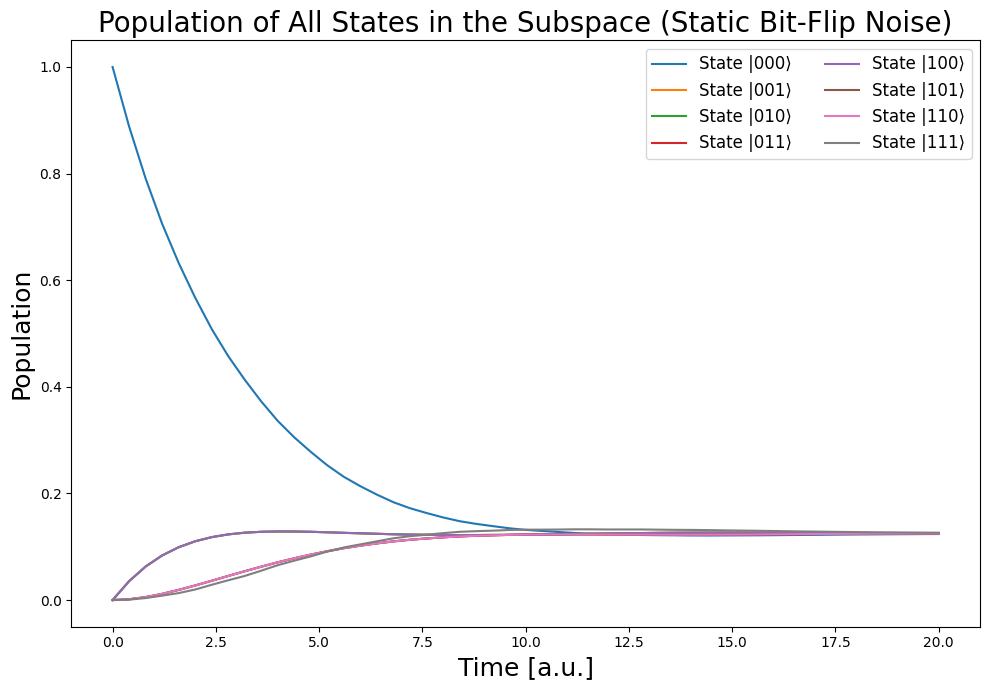

In [25]:
# Show population of all states in the subspace under static bit-flip noise

gamma_bitflip = 0.1

c_ops_bitflip = [
    np.sqrt(gamma_bitflip) * tensor(X, I, I),
    np.sqrt(gamma_bitflip) * tensor(I, X, I),
    np.sqrt(gamma_bitflip) * tensor(I, I, X)
]

Ep = 20
Hp = -Ep * sum(S)
def H_t(t):
    return (H(t) + Hp).to('csr')

# Simulate evolution with static bit-flip noise
results = mesolve(H_t, logical_zero * logical_zero.dag(), t_list, c_ops=c_ops_bitflip, e_ops=None, options={'store_states': True})

# Get populations for all basis states in the subspace
num_states = results.states[0].shape[0]
populations = np.zeros((len(t_list), num_states))
for idx, state in enumerate(results.states):
    populations[idx, :] = np.real(np.diag(state.full()))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
for i in range(num_states):
    plt.plot(t_list, populations[:, i], label=f"State |{i:0{int(np.log2(num_states))}b}⟩")
plt.xlabel("Time [a.u.]", fontsize=18)
plt.ylabel("Population", fontsize=18)
plt.title("Population of All States in the Subspace (Static Bit-Flip Noise)", fontsize=20)
plt.legend(fontsize=12, loc='upper right', ncol=2)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the sum of |c_coef| for all transitions out of the codespace (from logical 0 to non-logical states)
def sum_c_coef_out_of_codespace(t, args, logical_index=0, codespace_indices=[0, 1]):
    """
    Sums the absolute value of c_coef for transitions from logical_index (e.g., 0) to all states not in codespace_indices.
    """
    H_inst_t = args['args_H'](t)
    eigenvalues, eigenstates = H_inst_t.eigenstates()
    num_states = len(eigenstates)
    out_of_codespace_indices = [i for i in range(num_states) if i not in codespace_indices]
    total_c_coef = 0.0
    for b in out_of_codespace_indices:
        # Only consider transitions from logical_index to b
        c_coef = 0
        for i in range(args['n_qubits']):
            sigmam_i = tensor([sigmam() if j == i else qeye(2) for j in range(args['n_qubits'])])
            omega_a = eigenvalues[logical_index]
            omega_b = eigenvalues[b]
            if np.abs(omega_a - omega_b) < 1e-6:
                continue
            if omega_b > omega_a:
                Nba = bose_einstein_distribution(omega_b - omega_a, args['T'])
                g_ba = gab(omega_a, omega_b, args['lambda_2'])
                ma_ba = eigenstates[logical_index].dag() * sigmam_i * eigenstates[b] * eigenstates[b].dag() * sigmam_i.dag() * eigenstates[logical_index]
                c_coef += np.abs(np.sqrt(Nba * (g_ba ** 2) * ma_ba))
            elif omega_a > omega_b:
                Nab = bose_einstein_distribution(omega_a - omega_b, args['T'])
                g_ab = gab(omega_b, omega_a, args['lambda_2'])
                ma_ab = eigenstates[b].dag() * sigmam_i * eigenstates[logical_index] * eigenstates[logical_index].dag() * sigmam_i.dag() * eigenstates[b]
                c_coef += np.abs(np.sqrt((Nab + 1) * (g_ab ** 2) * ma_ab))
        total_c_coef += c_coef
    return total_c_coef

# Calculate the sum of |c_coef| for transitions out of codespace at each time step

sum_out_vec = []

Ep = 40
# Define args
args = {
    "args_H": lambda t: omega_t(t) * X_L + delta_t(t) * Z_L - Ep * sum(S),
    "n_qubits": 3,
    "lambda_2": 0.1,
    "T": 20
}
for t in t_list:
    sum_out_vec.append(
        sum_c_coef_out_of_codespace(t, args, logical_index=0, codespace_indices=[0, 1])
    )

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=t_list,
    y=sum_out_vec,
    mode='lines+markers',
    name="Sum of |c_coef| out of codespace"
))

fig.update_layout(
    title="Leakage Rate Out of Codespace Over Time",
    xaxis_title="Time",
    yaxis_title="Sum of |c_coef|",
    font=dict(family="sans-serif", size=18),
    legend_title="",
    template="plotly"
)


# Add constant line for βEp = Ep/T
T = args["T"]
beta_Ep = Ep / T
fig.add_trace(go.Scatter(
    x=t_list,
    y=[beta_Ep]*len(t_list),
    mode='lines',
    name=r"βEp = Ep/T",
    line=dict(color='black', dash='dash')
))

fig.update_layout(
    title="Leakage Rate Out of Codespace Over Time",
    xaxis_title="Time",
    yaxis_title="Sum of |c_coef|",
    font=dict(family="sans-serif", size=18),
    legend_title="",
    template="plotly"
)


fig.show()


# Calculate fidelity of logical_one over time with noise and plot with plotly

# Prepare for simulation
rho0 = logical_zero * logical_zero.dag()
rho1 = logical_one * logical_one.dag()
e_ops = [rho0, rho1]

# Simulate evolution with noise (using c_ops from c_ops_gen_new)
rho_init = logical_zero * logical_zero.dag()
prev_time = t_list[0]
fidelity_noise = []
for dt in t_list[1:]:
    c_ops, _ = c_ops_gen_new(dt, args)
    t_steps = [prev_time, dt]
    results = mesolve(args["args_H"], rho_init, t_steps, c_ops=c_ops, args=args, e_ops=e_ops, options={'store_states': True})
    prev_time = dt
    rho_init = results.states[-1]
    fidelity_noise.append(np.real(results.expect[1][0]))
fidelity_noise = [0.0] + fidelity_noise  # Start with 0 for t=0

# Plot with plotly
fig_fid_noise = go.Figure()
fig_fid_noise.add_trace(go.Scatter(
    x=t_list,
    y=fidelity_noise,
    mode='lines',
    name='Fidelity of $|1_L\rangle$ (Noise Model)'
))

fig_fid_noise.update_layout(
    title="Logical State Fidelity Over Time (Noise Model)",
    xaxis_title="Time",
    yaxis_title="Fidelity of $|1_L\rangle$",
    font=dict(family="sans-serif", size=18),
    legend_title="",
    template="plotly"
)

In [ ]:
# Parameters
gamma_dephasing = 0.05  # Dephasing rate per qubit


Ep = 100
# Define args
args = {
    "args_H": lambda t: H(t) - Ep * sum(S),
    "n_qubits": 3,
    "lambda_2": 0.1,
    "T": 20
}


# Dephasing collapse operators for each qubit
c_ops_dephasing = [
    np.sqrt(gamma_dephasing) * tensor(Z, I, I),
    np.sqrt(gamma_dephasing) * tensor(I, Z, I),
    np.sqrt(gamma_dephasing) * tensor(I, I, Z)
]

# Simulate evolution with dephasing only
results_dephasing = mesolve(
    args["args_H"], logical_zero * logical_zero.dag(), t_list,
    c_ops=c_ops_dephasing, e_ops=[logical_zero * logical_zero.dag(), logical_one * logical_one.dag()]
)
fidelity_dephasing = np.real(results_dephasing.expect[1])

# Plot with plotly
fig_dephasing = go.Figure()
fig_dephasing.add_trace(go.Scatter(
    x=t_list,
    y=fidelity_dephasing,
    mode='lines',
    name='Fidelity of $|1_L\rangle$ (Dephasing Only)'
))

fig_dephasing.update_layout(
    title="Logical State Fidelity Over Time (Dephasing Only)",
    xaxis_title="Time",
    yaxis_title="Fidelity of $|1_L\rangle$",
    font=dict(family="sans-serif", size=18),
    legend_title="",
    template="plotly"
)

fig_dephasing.show()

### Conclusion

For the energy-penalty term $E_p$ to effectively suppress both decoherence and dephasing, the corresponding collapse-operator rates must depend explicitly on the enlarged energy gap $\Delta E \approx \omega_0 + E_p$. In other words, setting
$$
\gamma(\Delta E)\;\propto\;S(\Delta E)\,,
$$
where $S(\omega)$ is the bath spectral density (or occupation factor) evaluated at the transition frequency $\Delta E$, ensures that as $E_p$ grows, the noise rates $\gamma(\Delta E)$ decrease—thereby protecting the logical subspace. Without this gap-dependence, fixed (phenomenological) rates remain unaffected by the penalty and cannot achieve suppression.  


### Next: examining the proposed noise model
We now begin examining the noise model proposed in:

Error Suppression and Error Correction in Adiabatic Quantum Computation: Techniques and Challenges
Kevin C. Young* and Mohan Sarovar; Robin Blume‑Kohout
Scalable and Secure Systems Research (08961), Sandia National Laboratories; Advanced Device Technologies (01425), Sandia National Laboratories
(Received 10 September 2012; revised 23 July 2013; published 13 November 2013)

The next cells will extract the model assumptions and implement the relevant bath / collapse-operator prescriptions from this work, then compare the resulting dynamics to the heuristic collapse-coefficient diagnostics above.

In [108]:
import numpy as np
from numpy.fft import rfftfreq, irfft
from scipy.interpolate import interp1d
from qutip import tensor, sigmax, qeye
import qutip as qt
import plotly.graph_objects as go

# --- 1/f noise generator ---
def generate_1f_noise_coeffs(t_grid,
                             n_qubits=3,
                             n_realizations=1000,
                             S0=1e3,
                             fmin=1e-6,
                             seed=None,
                             normalize=False):
    t_grid = np.asarray(t_grid, dtype=float)
    N = len(t_grid)
    dt = float(t_grid[1] - t_grid[0]) if N > 1 else 1.0
    freqs = rfftfreq(N, dt)
    S = np.zeros_like(freqs, dtype=float)
    mask = freqs >= fmin
    S[mask] = S0 / (2.0 * np.pi * freqs[mask])
    rng = np.random.default_rng(seed)
    xis = np.zeros((int(n_realizations), int(n_qubits), N), dtype=float)
    for r in range(n_realizations):
        for q in range(n_qubits):
            real_part = rng.normal(size=len(freqs))
            imag_part = rng.normal(size=len(freqs))
            spectrum = (real_part + 1j * imag_part) * np.sqrt(np.maximum(S, 0.0) / 2.0)
            spectrum[0] = 0.0
            x = irfft(spectrum, n=N)
            x = x - np.mean(x)
            if normalize:
                s = np.std(x)
                if s > 0:
                    x = x / s
            xis[r, q, :] = x
    return xis

# --- Noise summary ---
def summarize_noise_coefs(xis, method='sum_abs', axis_time=2):
    xis = np.asarray(xis)
    if method == 'sum_abs':
        per = np.sum(np.abs(xis), axis=axis_time)
    elif method == 'rms':
        per = np.sqrt(np.mean(xis**2, axis=axis_time))
    elif method == 'max':
        per = np.max(np.abs(xis), axis=axis_time)
    else:
        raise ValueError("Unknown method")
    mean_over_real = per.mean(axis=0)
    return per, mean_over_real

# --- Setup time grid and noise ---
n_qubits = 3
xis = generate_1f_noise_coeffs(t_grid, n_qubits=n_qubits, n_realizations=1, S0=1e3, fmin=1e-6, normalize=False)[0]
coeffs = [interp1d(t_grid, xis[q], kind='cubic', bounds_error=False, fill_value=(xis[q][0], xis[q][-1])) for q in range(n_qubits)]

# --- Build noise operators ---
X_op = sigmax()
I_op = qeye(2)
noise_ops = [tensor(X_op, I_op, I_op), tensor(I_op, X_op, I_op), tensor(I_op, I_op, X_op)]

noise_strength = 10
Ep = 50
# --- Hamiltonian function ---
def H_t(t):
    H_RAP = X_L * omega_t(t) + Z_L * delta_t(t)
    H_pen = -Ep * sum(S)
    Ht = H_RAP + H_pen
    H_noise = sum(float(coeffs[q](t)) * noise_strength * noise_ops[q] for q in range(n_qubits))
    return Ht + H_noise

# Use QuTiP's sesolve for propagation
H_func = lambda t, args: H_t(t)

result = qt.sesolve(H_func, logical_zero, t_list, [], args={})
fidelity = [qt.metrics.fidelity(psi, logical_one) for psi in result.states]

fig = go.Figure()
fig.add_trace(go.Scatter(x=t_list, y=fidelity, mode='lines', name='Fidelity to logical one'))
fig.update_layout(title='Logical |1> fidelity vs time (sesolve)', xaxis_title='time', yaxis_title='Fidelity', template='plotly_white')
fig.show()

print('Plotted logical one fidelity over time using sesolve.')

/Users/chenscheim/miniconda3/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning:

e_ops will be keyword only from qutip 5.3 for all solver



Plotted logical one fidelity over time using sesolve.


In [111]:
Ep_values = np.linspace(1, 50, 21)  # Example sweep: Ep from 0 to 10 in 21 steps
final_fidelities = []

# use tqdm

for Ep in tqdm(Ep_values):
    def H_t_sweep(t):
        H_RAP = X_L * omega_t(t) + Z_L * delta_t(t)
        H_pen = -Ep * sum(S)
        Ht = H_RAP + H_pen
        H_noise = sum(float(coeffs[q](t)) * noise_strength * noise_ops[q] for q in range(len(noise_ops)))
        return Ht + H_noise
    result = qt.sesolve(H_t_sweep, logical_zero, t_list, [], args={})
    final_fidelities.append(qt.metrics.fidelity(result.states[-1], logical_one))

fig = go.Figure()
fig.add_trace(go.Scatter(x=Ep_values, y=final_fidelities, mode='lines+markers', name='Final Fidelity'))
fig.update_layout(title='Final protocol fidelity vs Ep', xaxis_title='Ep', yaxis_title='Final Fidelity', template='plotly_white')
fig.show()

print('Plotted final protocol fidelity as a function of Ep.')

  0%|          | 0/21 [00:00<?, ?it/s]/Users/chenscheim/miniconda3/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning:

e_ops will be keyword only from qutip 5.3 for all solver

/Users/chenscheim/miniconda3/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning:

e_ops will be keyword only from qutip 5.3 for all solver

100%|██████████| 21/21 [00:11<00:00,  1.85it/s]



Plotted final protocol fidelity as a function of Ep.


In [119]:
import numpy as np
import plotly.graph_objects as go
import qutip as qt

Ep_values = np.linspace(1, 10, 21)
final_fidelities_noise = []
final_fidelities_dissipative = []
T = 10
gamma_sqrt = 0.01
noise_strength = 5

# 1/f noise protocol (sesolve)
for Ep in Ep_values:
    def H_t_noise(t):
        H_RAP = X_L * omega_t(t) + Z_L * delta_t(t)
        H_pen = -Ep * sum(S)
        Ht = H_RAP + H_pen
        H_noise = sum(float(coeffs[q](t)) * noise_strength * noise_ops[q] for q in range(len(noise_ops)))
        return Ht + H_noise
    result = qt.sesolve(H_t_noise, logical_zero, t_list, [], args={})
    final_fidelities_noise.append(qt.metrics.fidelity(result.states[-1], logical_one))

# Dissipative protocol (mesolve)
for Ep in Ep_values:
    def H_t_dissipative(t):
        H_RAP = H(t)
        Ht = H_RAP - Ep * sum(S)
        return Ht.to('csr')
    args_C = {"args_H": H_t_dissipative, "n_qubits": n_qubits, "lambda_2": gamma_sqrt, "T": T}
    rho_init = initial_state * initial_state.dag()
    prev_time = t_list[0]
    time_inter = t_list[1] - t_list[0]
    tot_time = t_list[1:]
    tot_time = np.append(tot_time, t_list[-1] + time_inter)
    for dt in tot_time:
        c_ops, c_s = c_ops_gen_new(dt, args=args_C)
        t_steps = [prev_time, dt]
        results = qt.mesolve(H_t_dissipative, rho_init, t_steps, c_ops=c_ops, args=args_C, e_ops=e_ops,
                             options={'store_states': True})
        prev_time = dt
        rho_init = results.states[-1]
    final_fidelity = results.expect[1][-1]
    final_fidelities_dissipative.append(final_fidelity)

fig = go.Figure()
fig.add_trace(go.Scatter(x=Ep_values, y=final_fidelities_noise, mode='lines+markers', name='1/f Noise Protocol'))
fig.add_trace(go.Scatter(x=Ep_values, y=final_fidelities_dissipative, mode='lines+markers', name='Dissipative Protocol'))
fig.update_layout(title='Final protocol fidelity vs Ep: 1/f Noise vs Dissipative', xaxis_title='Ep', yaxis_title='Final Fidelity', template='plotly_white')
fig.show()

print('Plotted comparison of final protocol fidelity vs Ep for both protocols.')

/Users/chenscheim/miniconda3/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning:

e_ops will be keyword only from qutip 5.3 for all solver



Plotted comparison of final protocol fidelity vs Ep for both protocols.
